<a href="https://colab.research.google.com/github/nowshad7/AI_Lab/blob/master/Extractive_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Author: Robiul Hasan Nowshad
##### Email: nowshad21aug@gmail.com


#Data

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#import rouge
from yellowbrick.cluster import KElbowVisualizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Ex_Summ/Data/entertainment

/content/drive/My Drive/Ex_Summ/Data/entertainment


In [ ]:
filename=input("Enter File Name: ")  
news = open(filename,"r")
text = news.read()

Enter File Name: 023.txt


In [ ]:
sentences = nltk.sent_tokenize(text)
sentences

["Famed music director Viotti dies\n\nConductor Marcello Viotti, director of Venice's famous La Fenice Theatre, has died in Germany at 50.",
 "Viotti, director of La Fenice since 2002, conducted at renowned opera houses worldwide including Milan's La Scala and the Vienna State Opera.",
 'His time at La Fenice coincided with its reopening in 2003 after it was destroyed by fire in 1996.',
 "He fell into a coma after suffering a stroke during rehearsals for Jules Massenet's Manon last week.",
 'He conducted some of the best orchestras in the world including the Berlin Philharmonic and the English Chamber Orchestra.',
 'Viotti was born in Switzerland and studied the piano, cello and singing at the Lausanne Conservatory.',
 'His career breakthrough came in 1982 when he won first prize at the Gino Marinuzzi conducting competition in Italy.',
 "Viotti established himself as chief conductor of the Turin Opera and went on to become chief conductor of Munich's Radio Orchestra.",
 "At La Fenice V

In [ ]:
art_size = len(sentences)
print(art_size)

13


#BERT Word  Embedinnings

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import logging
import matplotlib.pyplot as plt
% matplotlib inline
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, 
                                  )

model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
def BERT_emb(sentence):
  marked_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]
  token_vecs = hidden_states[-2][0]
  sentence_embedding = torch.mean(token_vecs, dim=0)
  return sentence_embedding.numpy()

In [ ]:
text = "Gallery unveils interactive tree."
emb = BERT_emb(text)
emb[0]

-0.13614129

In [ ]:
print ("Our final sentence embedding vector of shape:", len(emb))

Our final sentence embedding vector of shape: 768


In [ ]:
emb_Matrix = []
for sentence in sentences:
  emb = BERT_emb(sentence)
  emb_Matrix.append(emb)
print(len(emb_Matrix[0]))
print(len(emb_Matrix))

768
13


#Visualization

In [ ]:
from scipy.spatial.distance import pdist,squareform
array_similarity = squareform(pdist(emb_Matrix, metric='euclidean'))

Text(0.5, 1.0, 'visualizing sentence semantic similarity')

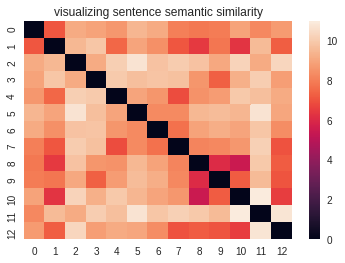

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(array_similarity)
plt.title('visualizing sentence semantic similarity')

In [ ]:
plt.savefig('/content/drive/My Drive/Ex_Summ/Data/ss02.png')

<Figure size 432x288 with 0 Axes>

#K-Means Clustering

In [ ]:
emb_sentences = pd.DataFrame(emb_Matrix)

In [ ]:
emb_sentences.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.143785,-0.002867,0.830029,-0.634028,-0.006272,-0.174886,-0.037025,0.570969,0.018755,-0.159353,-0.034033,-0.490067,0.070393,0.457877,-0.204329,0.511517,0.068630,-0.096759,-0.478556,-0.023198,0.038252,0.264795,0.058847,0.557685,0.008909,-0.078965,-0.280903,-0.028268,0.040021,0.116738,0.097507,0.075026,0.298647,0.250330,-0.172875,-0.461163,0.322825,-0.011986,0.018787,0.115114,...,-0.246376,-0.837186,-0.210558,-0.384532,-0.335349,-0.200237,0.208618,-0.065485,-0.010875,0.156140,-0.158124,0.818484,-0.197235,-0.019731,-0.449693,0.263318,0.055482,-0.094288,-0.216536,-0.180158,-0.227458,0.472537,0.181258,-0.199818,0.656865,-0.044748,-0.159893,0.225204,0.065465,-0.063469,0.056792,0.155117,0.689316,0.306131,0.566671,-0.145850,-0.410457,-0.218220,-0.043830,0.211640
1,-0.319877,0.020022,0.504869,-1.036966,-0.081475,-0.197848,-0.221577,0.427205,-0.397984,0.067870,-0.049541,-0.572025,0.169643,0.415886,0.146217,0.680513,0.611527,-0.324866,-0.429839,-0.390367,-0.024254,0.114576,0.152912,0.983136,-0.285729,-0.123055,-0.315710,-0.028317,-0.264192,0.131995,0.065682,0.282990,0.324636,-0.014835,-0.006523,-0.053094,0.331240,-0.039072,-0.147002,-0.514434,...,0.035118,-0.734397,0.010976,-0.315724,0.052296,0.139190,0.385074,-0.079344,-0.360272,0.575390,-0.241097,0.803480,-0.148073,0.049212,-0.330106,0.281733,-0.082773,0.129937,-0.092428,-0.254192,-0.445129,0.503620,-0.267078,-0.172942,0.246405,0.012484,0.157301,-0.163205,-0.125503,-0.115651,0.055411,-0.055104,0.592963,0.043050,0.078618,-0.112420,-0.014356,0.070685,0.045187,0.212186
2,-0.197623,-0.436448,-0.192796,-0.626506,0.432743,-0.031314,-0.014787,0.709196,-0.150916,-0.000497,0.254478,-0.624980,-0.234584,0.396208,-0.081927,0.504695,0.342728,-0.311517,-0.244712,-0.006331,-0.345677,-0.095366,-0.480952,0.456420,0.452239,0.241005,-0.249627,-0.230947,-0.097992,0.091574,0.592924,-0.241856,0.195069,-0.515655,-0.045208,-0.054334,0.389527,0.067624,-0.118877,0.330728,...,-0.266601,-0.686790,0.371765,-0.269111,0.204312,-0.711984,0.053018,-0.036362,0.054371,0.153772,0.245131,0.227925,-0.009991,0.054740,-0.322595,0.056344,-0.283057,-0.148406,0.427165,0.077012,-0.444472,0.286634,0.004861,-0.222506,0.420780,-0.169380,0.038460,0.169091,0.199697,-0.281474,-0.054045,-0.484868,-0.328114,0.219385,0.618521,-0.144901,-0.187731,0.136785,0.037302,0.580442
3,-0.107770,-0.132095,-0.289453,-0.540420,0.352394,-0.317694,0.222445,0.685462,-0.093629,0.140991,0.187261,-0.174239,-0.095030,0.365468,-0.001611,0.685414,0.416414,-0.377994,-0.305168,-0.207150,-0.287034,0.301280,-0.702736,0.339981,0.353553,-0.201284,-0.217782,0.367076,-0.215092,0.088126,-0.092546,0.083610,0.069407,-0.330040,0.208084,-0.019174,0.076561,-0.110935,-0.257211,0.007281,...,-0.044016,-0.478376,0.335947,0.087988,-0.154042,-0.067897,-0.001261,-0.220254,0.422285,0.084761,-0.058576,0.669024,-0.279001,0.031348,-0.206077,0.104984,0.730766,-0.103983,-0.334893,0.071510,-0.404368,0.622895,0.227217,-0.274955,0.423199,-0.271659,-0.082128,-0.020837,-0.014191,-0.490369,-0.073076,-0.574992,0.308985,-0.292240,0.150901,0.374248,-0.202548,-0.270814,-0.220839,0.127674
4,-0.315379,0.174251,-0.071889,-0.599465,0.023909,-0.579540,-0.776897,0.508723,-0.541970,0.174540,0.068720,-0.497355,0.028592,0.526679,-0.209888,0.437570,-0.054252,-0.527403,-0.550416,-0.378013,-0.183387,0.645463,0.006523,0.706343,0.019547,-0.028588,-0.631901,0.264813,-0.198782,-0.299628,-0.052640,0.200667,0.053357,-0.076478,-0.423411,-0.024990,0.261439,0.162899,-0.361147,-0.015800,...,-0.250513,-0.713621,0.148333,-0.020156,0.243475,-0.020908,0.452152,0.231246,-0.017841,0.723179,-0.301054,0.465333,-0.140243,0.045763,-0.321096,0.098698,0.216965,-0.281665,-0.584941,-0.532864,-0.197879,0.770382,0.030075,-0.113293,0.377719,-0.048276,0.249950,-

#Understanding the Data

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(emb_sentences)
print(np.sum(pca.explained_variance_ratio_))

0.3760785937369431


In [ ]:
pca_sentence_features = pca.transform(emb_sentences)

Text(0.5, 1.0, '2D PCA projection of embedded sentences from BERT')

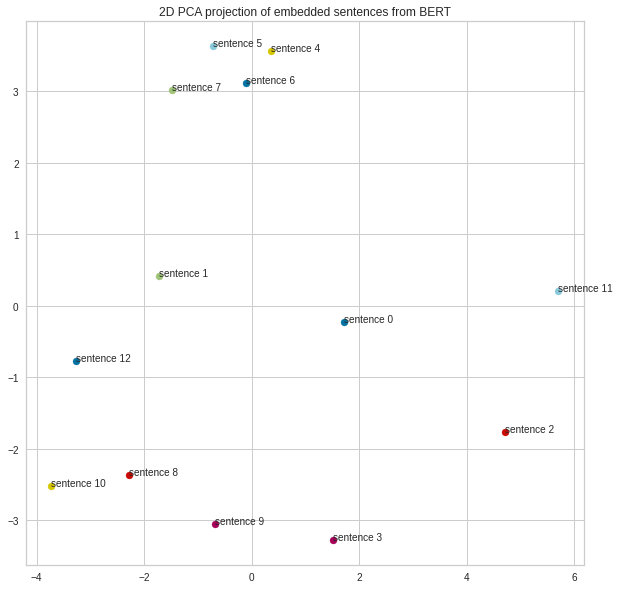

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(pca_sentence_features)):
  plt.scatter(pca_sentence_features[i,0],pca_sentence_features[i,1])
  plt.annotate('sentence '+ str(i),(pca_sentence_features[i,0],pca_sentence_features[i,1]))
plt.title('2D PCA projection of embedded sentences from BERT')

##Elbow Method

In [ ]:
def Elbow_Method(emb_sentences):
  Sum_of_squared_distances = []
  K = range(1,art_size)
  for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(emb_sentences)
    Sum_of_squared_distances.append(km.inertia_)
  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

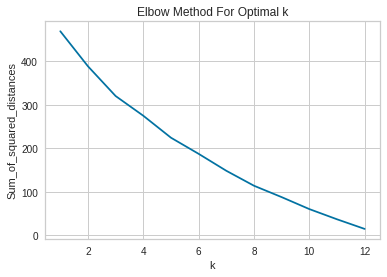

In [ ]:
Elbow_Method(emb_sentences)

##Silhouette Method




In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Use silhouette score to find optimal number of clusters to segment the data
num_clusters = np.arange(2,art_size)
results = {}
for size in num_clusters:
    model = KMeans(n_clusters = size).fit(emb_sentences)
    predictions = model.predict(emb_sentences)
    results[size] = silhouette_score(emb_sentences, predictions)

best_size = max(results, key=results.get)
print(best_size)

2


##K-Mean Model

In [ ]:
#num_clusters = 4
def KMean_Clustering(df):
    num_clusters = int(input("Enter Elbow point form graph: "))
    km = KMeans(n_clusters=num_clusters)
    km.fit(df)
    #plt.scatter(emb_sentences, c=km.labels_, cmap='rainbow')
    clusters = km.labels_.tolist()   
    centers = km.cluster_centers_

    return clusters, centers

In [ ]:
clusters, centers = KMean_Clustering(emb_sentences)
print(clusters)
print(centers)

Enter Elbow point form graph: 3
[2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1]
[[-0.29536652 -0.23433813  0.32292406 ... -0.17019452  0.11631446
   0.30811334]
 [-0.24906206 -0.10129747  0.04396008 ...  0.05257991 -0.07642751
   0.17435527]
 [-0.31453223  0.04519706  0.32734626 ...  0.04379937 -0.05261581
   0.03845191]]


In [ ]:
print(emb_Matrix[0])

[-1.43785149e-01 -2.86701089e-03  8.30029428e-01 -6.34027600e-01
 -6.27219677e-03 -1.74886391e-01 -3.70248184e-02  5.70969343e-01
  1.87554490e-02 -1.59352958e-01 -3.40327695e-02 -4.90067124e-01
  7.03933910e-02  4.57877100e-01 -2.04329461e-01  5.11517048e-01
  6.86298236e-02 -9.67589319e-02 -4.78555620e-01 -2.31978334e-02
  3.82524058e-02  2.64794916e-01  5.88470250e-02  5.57684958e-01
  8.90862569e-03 -7.89645836e-02 -2.80902714e-01 -2.82683522e-02
  4.00210917e-02  1.16738021e-01  9.75070298e-02  7.50255138e-02
  2.98646629e-01  2.50329643e-01 -1.72874540e-01 -4.61162925e-01
  3.22824925e-01 -1.19860973e-02  1.87867731e-02  1.15113512e-01
 -1.44733608e-01 -4.54163730e-01  6.75085306e-01  1.48659080e-01
  1.12962320e-01  3.59827042e-01  3.10502015e-02 -8.48506689e-02
  5.34667552e-01 -2.25524247e-01 -4.56597567e-01  2.85002679e-01
 -2.98299074e-01 -8.03312287e-05  4.73156571e-02  2.02335179e-01
 -3.11275899e-01 -6.07385159e-01  2.33745322e-01 -1.01943240e-02
 -1.86457992e-01  5.48678

#Extract Summary

In [ ]:
import math
def ecd_dist(x,y):
  return math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

In [ ]:
idx = []
for center in centers:
  c_dist = []  
  for emb_M in emb_Matrix:
    dist = ecd_dist(center, emb_M)
    print(dist)
    c_dist.append(dist)
  idx.append(c_dist.index(min(c_dist)))
  #print(c_dist)
  print("index = ",c_dist.index(min(c_dist)))
print(idx)

7.3976780389905175
8.36067627579352
4.57552201937351
8.470324613731032
8.788702194603534
9.715956615860748
8.696602346983774
8.99444222765936
8.746218379406812
8.11437153372163
9.58058265698879
4.57552201937351
9.503703569619432
index =  2
7.058309836341039
6.018764979067432
8.518952218064896
5.992683886355143
8.01424078416127
8.19770544548074
7.7452337728058485
6.947155450116129
4.0385104675877646
4.031889581234247
4.454923068846292
9.142221709680221
4.707919170421288
index =  9
5.6603325875797985
4.803000640734699
8.344417664412482
8.08199175851279
5.197509567297782
6.026016304059654
5.592513654733809
4.463763615836855
6.353702941501004
6.773661760722505
6.97814841916544
8.16264805529844
6.348169566575776
index =  7
[2, 9, 7]


In [ ]:
idx.sort()
print(idx)

[2, 7, 9]


In [ ]:
summary = ""
for i in idx:
  summary = summary + sentences[i]

#Summary

In [ ]:
summary

"His time at La Fenice coincided with its reopening in 2003 after it was destroyed by fire in 1996.Viotti established himself as chief conductor of the Turin Opera and went on to become chief conductor of Munich's Radio Orchestra.The last opera he directed at La Fenice was Massenet's Le Roi de Lahore."